#### 道格拉斯算法实现

In [1]:

import math
from shapely import wkt, geometry
import matplotlib.pyplot as plt
 
 
class Point:
    """点类"""
    x = 0.0
    y = 0.0
    index = 0  # 点在线上的索引
 
    def __init__(self, x, y, index):
        self.x = x
        self.y = y
        self.index = index
 
 
class Douglas:
    """道格拉斯算法类"""
    points = []
    D = 100  # 容差
 
    def readPoint(self, map = None):
        """生成点要素"""
        if map == None:
            g = [(1,4),(2,3),(3, 5),(4,2),(6,4),(8,4),(9,5),(12, 4),(15 ,8),(12, 10),(9, 9),(8, 10),(7, 8),(6, 11),(5, 12),(4, 10),(3, 11),(1, 4)]
        else:
            g = map
        for i in range(len(g)):
            self.points.append(Point(g[i][0], g[i][1], i))
 
    def compress(self, p1, p2):
        """具体的抽稀算法"""
        swichvalue = False


        # 一般式直线方程系数 A*x+B*y+C=0,利用点斜式,分母可以省略约区
        # A=(p1.y-p2.y)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        A = (p1.y - p2.y)
        # B=(p2.x-p1.x)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        B = (p2.x - p1.x)
        # C=(p1.x*p2.y-p2.x*p1.y)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        C = (p1.x * p2.y - p2.x * p1.y)
 
        m = self.points.index(p1)
        n = self.points.index(p2)
        distance = {}
        middle = None
 
        if (n == m + 1):
            return
        # 计算中间点到直线的距离
        for i in range(m + 1, n):
            d = abs(A * self.points[i].x + B * self.points[i].y + C) / math.sqrt(math.pow(A, 2) + math.pow(B, 2))
            distance[i] = d
 
        dmax_index = max(distance, key=distance.get)
        dmax = distance[dmax_index]
 
        if dmax > self.D:
            swichvalue = True
        else:
            swichvalue = False
 
        if (not swichvalue):
            i = m+1
            while i != n:
                del self.points[i]
                n = n - 1
        else:
            middle = self.points[dmax_index]
            self.compress(p1, middle)
            self.compress(middle, p2)
 
    def printPoint(self):
        """打印数据点"""
        for p in self.points:
            print("%d,%f,%f" % (p.index, p.x, p.y))

#### 算法运行效果

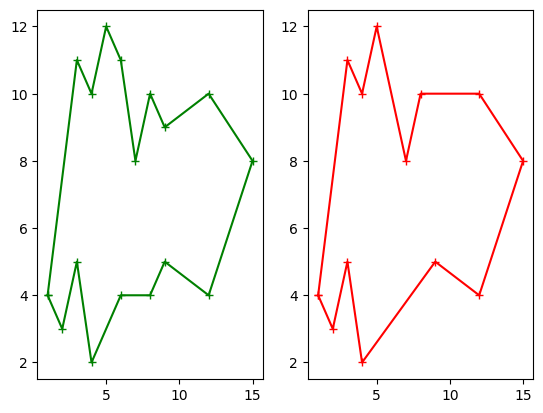

In [2]:
d = Douglas()
d.D = 1
d.readPoint()


fig = plt.figure()
a1 = fig.add_subplot(121)
dx = []
dy = []
for i in range(len(d.points)):
    dx.append(d.points[i].x)
    dy.append(d.points[i].y)
a1.plot(dx, dy, color='g', linestyle='-', marker='+')
p1 = d.points[0] 
p2 = d.points[-2]
d.compress(p1, p2)

# 抽稀之后绘制
dx1 = []
dy1 = []
a2 = fig.add_subplot(122)
for p in d.points:
    dx1.append(p.x)
    dy1.append(p.y)
a2.plot(dx1, dy1, color='r', linestyle='-', marker='+')


plt.show()

In [2]:
plt.show()

#### 获得地图数据

In [3]:
import json

# 加载GeoJSON文件
with open('USA.geo.json', 'r') as f:
    geojson_data = json.load(f)

# 提取坐标
def extract_coordinates(geojson):
    coordinates = []
    if 'features' in geojson:
        for feature in geojson['features']:
            if 'geometry' in feature and 'coordinates' in feature['geometry']:
                coordinates.append(feature['geometry']['coordinates'])
    return coordinates

coordinates = extract_coordinates(geojson_data)


In [4]:
coord = coordinates[0]

In [5]:
map = coord[5][0]

In [6]:
map_int = [[int(value * 100) for value in sublist] for sublist in map]


#### 对地图多边形使用简化算法

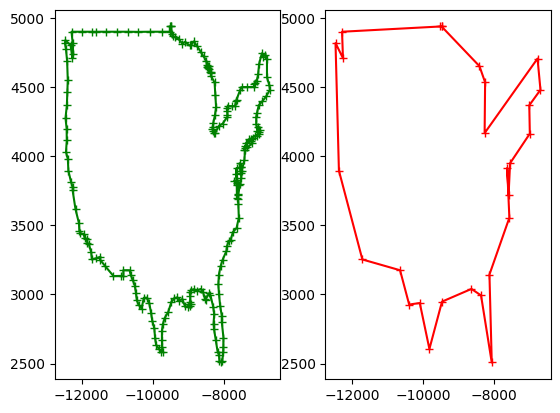

In [8]:

d = Douglas()
d.D = 100
d.readPoint(map=map_int)


fig1 = plt.figure()
a3 = fig1.add_subplot(121)
dx = []
dy = []
for i in range(len(d.points)):
    dx.append(d.points[i].x)
    dy.append(d.points[i].y)
a3.plot(dx, dy, color='g', linestyle='-', marker='+')
p1 = d.points[0] 
p2 = d.points[-2]
d.compress(p1, p2)

# 抽稀之后绘制
dx1 = []
dy1 = []
a4 = fig1.add_subplot(122)
for p in d.points:
    dx1.append(p.x)
    dy1.append(p.y)
a4.plot(dx1, dy1, color='r', linestyle='-', marker='+')


plt.show()

In [10]:
print(f"原来的边数:{len(dx) - 1}\n简化后的边数:{len(dx1) - 1}")

原来的边数:232
简化后的边数:27


#### 实现扫描线填充

In [11]:
import matplotlib.pyplot as plt

class Edge:
    def __init__(self, ymax, x, inverse_slope):
        self.ymax = ymax
        self.x = x
        self.inverse_slope = inverse_slope

def create_edge_table(vertices):
    edge_table = {}
    n = len(vertices)
    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        
        if y1 == y2:
            continue
        
        if y1 > y2:
            x1, y1, x2, y2 = x2, y2, x1, y1
        
        inverse_slope = (x2 - x1) / (y2 - y1)
        edge = Edge(ymax=y2, x=x1, inverse_slope=inverse_slope)
        
        if y1 in edge_table:
            edge_table[y1].append(edge)
        else:
            edge_table[y1] = [edge]
    
    return edge_table

def scanline_fill(vertices):
    edge_table = create_edge_table(vertices)
    active_edge_table = []
    y = min(edge_table.keys())
    
    while edge_table or active_edge_table:
        if y in edge_table:
            active_edge_table.extend(edge_table[y])
            del edge_table[y]
        
        active_edge_table = [edge for edge in active_edge_table if edge.ymax > y]
        active_edge_table.sort(key=lambda edge: edge.x)
        
        for i in range(0, len(active_edge_table), 2):
            x1 = active_edge_table[i].x
            x2 = active_edge_table[i + 1].x
            plt.plot([x1, x2], [y, y], color='black')
        
        y += 1
        for edge in active_edge_table:
            edge.x += edge.inverse_slope

def plot_polygon(vertices):
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]
        plt.plot([x1, x2], [y1, y2], color='black')



In [12]:
import time

#### 分别测试原始图像的填充效果和简化后的图像的填充效果

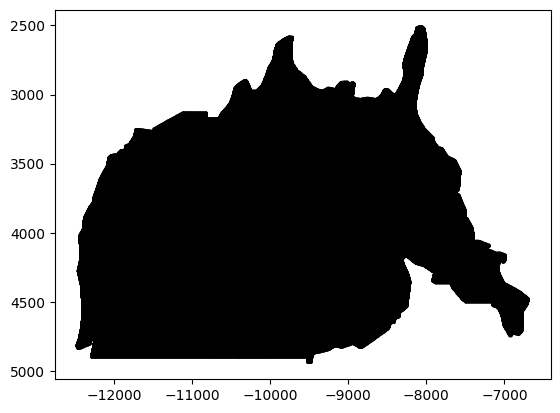

填充时间: 1.148476


In [14]:


vertices = [[x, y] for x, y in zip(dx[:-1], dy[:-1])]
plot_polygon(vertices)
start_time = time.time()
for i in range(10):
    scanline_fill(vertices)
end_time = time.time()
plt.gca().invert_yaxis()
plt.show()

print(f"填充时间:{(end_time - start_time) / 10 : .6f}")



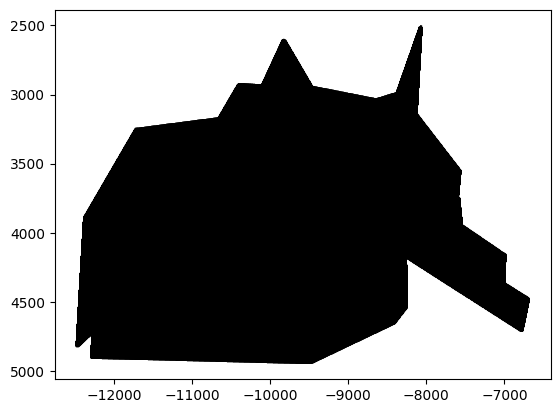

填充时间: 0.993049


In [15]:
vertices = [[x, y] for x, y in zip(dx1[:-1], dy1[:-1])]
plot_polygon(vertices)
start_time = time.time()
for i in range(10):
    scanline_fill(vertices)
end_time = time.time()
plt.gca().invert_yaxis()
plt.show()

print(f"填充时间:{(end_time - start_time) / 10 : .6f}")